# Quickstart Base using StateGraph
Learn more about [StateGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#stategraph). It is the preferred approach since it is far more flexible than [MessageGraph](https://langchain-ai.github.io/langgraph/reference/graphs/#messagegraph) for an expansive overall state and can handle additional key values to be accessible across the graph.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain-openai # No langchain install needed

In [ ]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

Notice how we have to explicitly handle `"messages"` or other keys in our state when interacting with the model

In [ ]:
from typing import Annotated, TypedDict

from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import START, END, StateGraph, MessagesState
from langgraph.graph.message import AnyMessage, add_messages
from langchain_openai import ChatOpenAI

# this is the default state  same as "MessageState" TypedDict but allows us accessibility to
# custom keys to our state like user's details
class GraphsState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    # user_id: int

graph = StateGraph(GraphsState)

# Can be any chat model integration https://python.langchain.com/v0.2/docs/integrations/chat/
model = ChatOpenAI(temperature=0)

def _call_model(state: GraphsState):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}

graph.add_edge(START, "modelNode")
graph.add_node("modelNode", _call_model)
graph.add_edge("modelNode", END)

graph_runnable = graph.compile()

### Let us visualize it using [Mermaid](https://langchain-ai.github.io/langgraph/how-tos/visualization/)

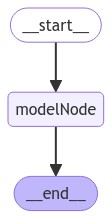

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph_runnable.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Talk to the Model

Here we can have a conversation with the model accounting for `"message"` key. Notice we sometimes can't do math, like *area of a circle*, with a Large **Language** Model. We can solve this and many complex problems by using tooling specifically the [ToolNode](https://langchain-ai.github.io/langgraph/how-tos/tool-calling/).

In [ ]:
# simple invocation
# graph_runnable.invoke({"messages": HumanMessage("What is your name?")})

while True:
  user = input("User (q/Q to quit): ")
  if user in {"q", "Q"}:
    print("AI: Byebye")
    break
  for output in graph_runnable.stream({"messages": HumanMessage(user)}, stream_mode="updates"):
    last_message = next(iter(output.values()))['messages'][-1]
    last_message.pretty_print()

User (q/Q to quit): hi
================================== Ai Message ==================================

Hello! How can I assist you today?
User (q/Q to quit): what is the area of a circle with radius 5?
================================== Ai Message ==================================

The area of a circle is calculated using the formula A = πr^2, where r is the radius of the circle.

Given that the radius of the circle is 5, we can substitute this value into the formula:

A = π(5)^2
A = π(25)
A = 25π

Therefore, the area of a circle with radius 5 is 25π square units.
User (q/Q to quit): q
AI: Byebye
